# Make a Survey Overview

**Goal**: Make a nice DEM overview raster using the dem

**Approach**: 
1. Create an Overview Raster with HillShade
2.  Grab all pit locations

## Process:

### Step 1. Create an Overview Raster with HillShade

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, LayerData, PointData, SiteData 
from snowxsql.conversions import raster_to_rasterio
from rasterio.plot import show
from sqlalchemy.sql import func
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
import time 
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Polygon
from geoalchemy2.shape import from_shape, to_shape

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)

data_name = 'snow off digital elevation model'
surveyors = 'USGS'
res = 20

# Form a polygon to clip at the max extent (figured out in advance)
x1 = 733773.4393990583
x2 = 760000.1485602345
y1 = 4319989.610224843
y2 = 4329803.647593204
extent = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely

# Make it usable to the db
extent_ewkt = from_shape(extent, srid=26912).ST_AsEWKT()        # Save one for the database
extent_df = gpd.GeoDataFrame({'geometry':[extent]})     # Save one for plotting

# Define a function to reduce the same code used for getting the dem and hillshade
def filter_and_return(session, base, data_name, surveyors, extent):
    '''
    Small function to apply redundent filters and raster making
    '''
    q = session.query(func.ST_AsTiff(func.ST_Clip(base, extent)))
    q = q.filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)
    rasters = q.all()
    dataset = raster_to_rasterio(session, rasters)[0]
    return dataset

# Create the base query to reduce code 
bq = func.ST_Rescale(ImageData.raster, res, -1 * res, 'blinear')

# Retrieve the dem
base = gfunc.ST_Union(bq, type_=Raster)
dem = filter_and_return(session, base, data_name, surveyors, extent_ewkt)

# Retrieve the hillshade
base = func.ST_Hillshade(gfunc.ST_Union(bq, type_=Raster))
hillshade = filter_and_return(session, base, data_name, surveyors, extent_ewkt)

### Step 2. Grab locations of pits for plotting

In [2]:
# Write a simple function to retrieve positional points of data
def grab_points(session, TableClass, data_name, distinct=False):
    '''
    Returns a dataframe of geometric points
    '''
    q = session.query(TableClass.geom).filter(TableClass.type == data_name)
    if distinct:
        q = q.distinct()
        
    points = q.all()
    # Make the points useable in plotting
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in points]})
    return df

In [3]:
# Grab our pits by selecting hand hardness profiles
pits = grab_points(session, LayerData, 'hand_hardness', distinct=True)
print(pits)

                           geometry
0    POINT (743040.000 4324967.000)
1    POINT (741377.000 4326992.000)
2    POINT (742531.000 4322632.000)
3    POINT (745093.000 4322617.000)
4    POINT (745477.000 4322480.000)
..                              ...
162  POINT (747771.000 4322500.000)
163  POINT (743548.000 4324077.000)
164  POINT (745340.000 4322754.000)
165  POINT (754173.000 4325871.000)
166  POINT (745598.000 4323988.000)

[167 rows x 1 columns]


### Step . Plot it all!

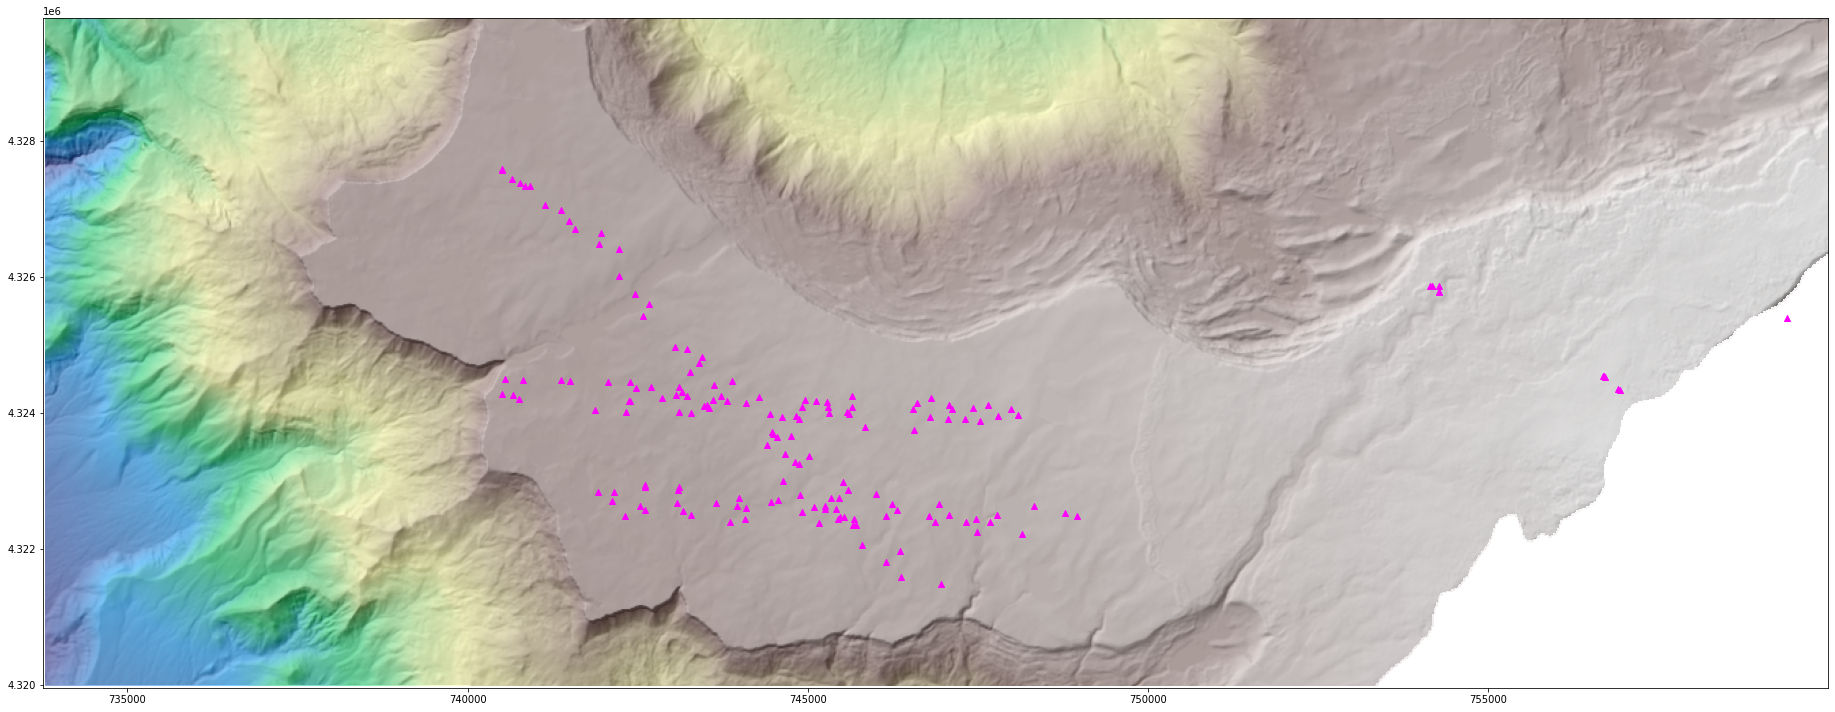

In [4]:
fig, ax = plt.subplots(1,1, figsize=(32, 16))
show(hillshade, ax=ax, cmap='gray', transform=hillshade.transform)

show(dem, ax=ax, alpha=0.5, cmap='terrain', transform=dem.transform)

pits.plot(ax=ax, marker='^' , color='magenta', label='pits')